# Iris K-means Clustering Notebook

アヤメ (Iris) データセットに対して K-means クラスタリングを行い、特徴量の選択やクラスタ数 \(k\) の変更による結果を可視化します。


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="whitegrid")


## データ読み込み


In [3]:
def find_data_path(filename: str = "iris.csv", search_depth: int = 4) -> Path:
    current = Path.cwd().resolve()
    candidates = [current / filename]
    candidates.extend(parent / filename for parent in current.parents[:search_depth])

    for path in candidates:
        if path.exists():
            return path

    raise FileNotFoundError(
        f"Could not find {filename}. Checked: {[str(path) for path in candidates]}"
    )


def load_iris_dataframe() -> pd.DataFrame:
    path = find_data_path()
    df = pd.read_csv(path)
    renamed_columns = {
        "sepal.length (cm)": "sepal.length",
        "sepal.width (cm)": "sepal.width",
        "petal.length (cm)": "petal.length",
        "petal.width (cm)": "petal.width",
    }
    df = df.rename(columns=renamed_columns)
    species_map = {0: "setosa", 1: "versicolor", 2: "virginica"}
    df["species"] = df["target"].map(species_map)
    return df


df_iris = load_iris_dataframe()
df_iris.head()


,sepal.length,sepal.width,petal.length,petal.width,target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


## 特徴量とクラスタ数の設定


In [4]:
FEATURE_MODES: dict[str, list[str]] = {
    "all": ["sepal.length", "sepal.width", "petal.length", "petal.width"],
    "sepal": ["sepal.length", "sepal.width"],
    "petal": ["petal.length", "petal.width"],
}

FEATURE_MODE = "all"  # "all", "sepal", "petal" から選択
CUSTOM_FEATURES: list[str] | None = None
N_CLUSTERS_OPTIONS = [3]  # 例: [3, 4, 5]
RANDOM_STATE = 42


def resolve_feature_names(feature_mode: str, custom_features: list[str] | None) -> list[str]:
    if custom_features:
        return custom_features
    try:
        return FEATURE_MODES[feature_mode]
    except KeyError:
        available = ", ".join(FEATURE_MODES)
        raise ValueError(f"Unknown feature_mode '{feature_mode}'. Choose from: {available}")


## K-means 実行用ユーティリティ


In [5]:
def run_kmeans(
    data: pd.DataFrame,
    feature_names: list[str],
    cluster_options: list[int],
    random_state: int = 42,
):
    X = data[feature_names].to_numpy()
    results = []

    for n_clusters in cluster_options:
        pipeline = make_pipeline(
            StandardScaler(),
            KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state),
        )
        labels = pipeline.fit_predict(X)

        scaler = pipeline.named_steps["standardscaler"]
        kmeans = pipeline.named_steps["kmeans"]
        scaled_X = scaler.transform(X)
        centroids_scaled = kmeans.cluster_centers_
        centroids = scaler.inverse_transform(centroids_scaled)

        results.append(
            {
                "n_clusters": n_clusters,
                "pipeline": pipeline,
                "labels": labels,
                "scaled_X": scaled_X,
                "centroids_scaled": centroids_scaled,
                "centroids": centroids,
                "inertia": kmeans.inertia_,
            }
        )

    return results, X


## クラスタリングの実行


In [6]:
feature_names = resolve_feature_names(FEATURE_MODE, CUSTOM_FEATURES)
print(f"Using features: {feature_names}")

kmeans_results, X_all = run_kmeans(
    data=df_iris,
    feature_names=feature_names,
    cluster_options=N_CLUSTERS_OPTIONS,
    random_state=RANDOM_STATE,
)


Using features: ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']


## 結果の確認


In [7]:
for result in kmeans_results:
    n_clusters = result["n_clusters"]
    labels = result["labels"]
    inertia = result["inertia"]
    print(f"k = {n_clusters} | inertia = {inertia:.2f}")
    display(
        df_iris.assign(cluster=labels)[feature_names + ["cluster", "species"]].head()
    )


k = 3 | inertia = 139.82


,sepal.length,sepal.width,petal.length,petal.width,cluster,species
0,5.1,3.5,1.4,0.2,1,setosa
1,4.9,3.0,1.4,0.2,1,setosa
2,4.7,3.2,1.3,0.2,1,setosa
3,4.6,3.1,1.5,0.2,1,setosa
4,5.0,3.6,1.4,0.2,1,setosa


## 可視化関数


In [8]:
def plot_clusters_2d(
    X: np.ndarray,
    labels: np.ndarray,
    centroids: np.ndarray,
    feature_names: list[str],
    title: str,
):
    fig, ax = plt.subplots(figsize=(8, 6))
    palette = sns.color_palette("deep", n_colors=len(np.unique(labels)))

    for cluster_id, color in zip(sorted(np.unique(labels)), palette):
        mask = labels == cluster_id
        ax.scatter(
            X[mask, 0],
            X[mask, 1],
            label=f"Cluster {cluster_id}",
            color=color,
            edgecolor="black",
            alpha=0.8,
        )

    ax.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="X",
        s=200,
        color="black",
        label="Centroids",
    )

    xlabel = feature_names[0].replace(".", " ").title()
    ylabel = feature_names[1].replace(".", " ").title()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    return ax


def plot_clusters_pca(
    scaled_X: np.ndarray,
    labels: np.ndarray,
    centroids_scaled: np.ndarray,
    title: str,
):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(scaled_X)
    centroids_pca = pca.transform(centroids_scaled)

    fig, ax = plt.subplots(figsize=(8, 6))
    palette = sns.color_palette("deep", n_colors=len(np.unique(labels)))

    for cluster_id, color in zip(sorted(np.unique(labels)), palette):
        mask = labels == cluster_id
        ax.scatter(
            X_pca[mask, 0],
            X_pca[mask, 1],
            label=f"Cluster {cluster_id}",
            color=color,
            edgecolor="black",
            alpha=0.8,
        )

    ax.scatter(
        centroids_pca[:, 0],
        centroids_pca[:, 1],
        marker="X",
        s=200,
        color="black",
        label="Centroids",
    )

    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    return ax


## クラスタリング結果の可視化


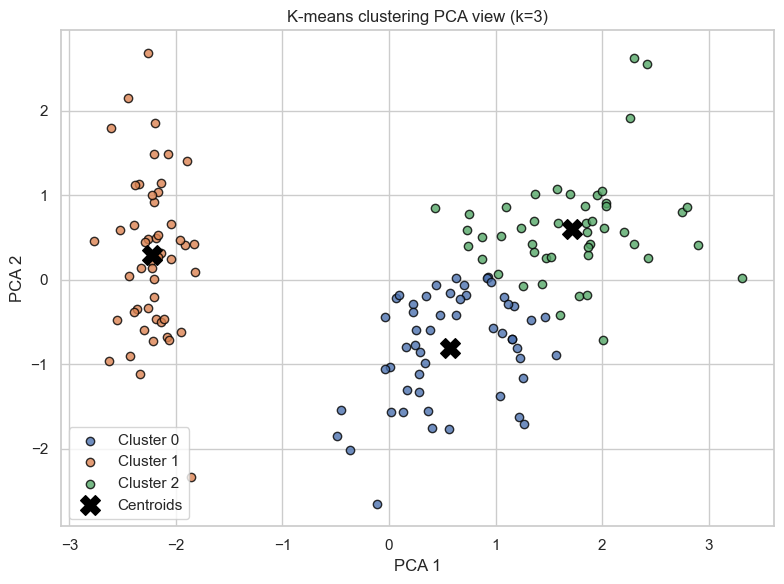

In [9]:
for result in kmeans_results:
    n_clusters = result["n_clusters"]
    labels = result["labels"]
    centroids = result["centroids"]
    centroids_scaled = result["centroids_scaled"]
    scaled_X = result["scaled_X"]

    if len(feature_names) == 2:
        plot_clusters_2d(
            X=X_all,
            labels=labels,
            centroids=centroids,
            feature_names=feature_names,
            title=f"K-means clustering (k={n_clusters})",
        )
        plt.show()
    else:
        plot_clusters_pca(
            scaled_X=scaled_X,
            labels=labels,
            centroids_scaled=centroids_scaled,
            title=f"K-means clustering PCA view (k={n_clusters})",
        )
        plt.show()
